## Poisonous mushrooms - PCA, KMeans and Gaussian Mixture Models


This is a project based on a classic dataset on poisonous mushrooms.  It contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature set is binarized, as all the observations are categorical.

This project is based on a homework assignment for the MIDS (Masters in Data Science) program at The University of California, Berkeley.

I'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once I've projected the data to 2 dimensions, I'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, I'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.


In [1]:
%matplotlib inline

import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

warnings.filterwarnings("ignore", category=UserWarning) 

Load feature names.

In [2]:
feature_names = []
with open('mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))
#print(feature_names)

('Loaded feature names:', 126)


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

((7000L, 126L), (1124L, 126L))


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [4]:
def P1():

    # PCA with 50 components
    n_comp = 50
    pca_mod = PCA(n_components = n_comp)
    pca_mod.fit(train_data)

    print('Explained variance ratio: \n', pca_mod.explained_variance_ratio_)
    print('Cumulative explained variance: \n', np.cumsum(pca_mod.explained_variance_ratio_))

P1()

('Explained variance ratio: \n', array([ 0.16404331,  0.13323479,  0.10173457,  0.07063356,  0.03866646,
        0.03680804,  0.03128239,  0.02733737,  0.0261649 ,  0.02230943,
        0.02048173,  0.01868331,  0.01734422,  0.01684361,  0.01518819,
        0.01508618,  0.01429134,  0.01412013,  0.01325045,  0.01146379,
        0.01071066,  0.01065747,  0.01040967,  0.00993699,  0.0090807 ,
        0.00869326,  0.00795617,  0.00775825,  0.0073757 ,  0.00700276,
        0.00641233,  0.00614513,  0.00572345,  0.00533629,  0.00525936,
        0.00502674,  0.00499042,  0.00455942,  0.00452784,  0.00439788,
        0.00419489,  0.00397702,  0.00370042,  0.00359528,  0.00338124,
        0.00298986,  0.0027203 ,  0.00235705,  0.00221399,  0.00204422]))
('Cumulative explained variance: \n', array([ 0.16404331,  0.2972781 ,  0.39901267,  0.46964623,  0.50831269,
        0.54512074,  0.57640313,  0.6037405 ,  0.62990541,  0.65221483,
        0.67269656,  0.69137987,  0.70872409,  0.7255677 ,  0.7

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

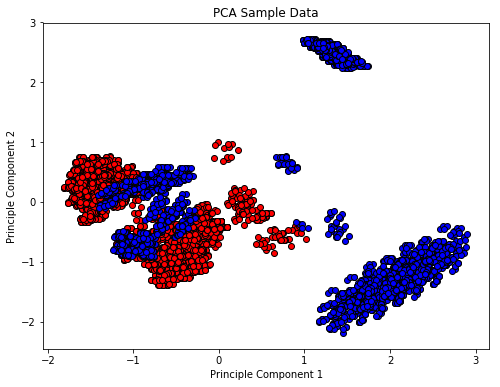

In [5]:
def P2():

    n_comp = 2
    pca_mod = PCA(n_components = 2)
    train_data_transformed = pca_mod.fit_transform(train_data)

    #print('Explained variance ratio: \n', pca_mod.explained_variance_ratio_)
    #print('Cumulative explained variance: \n', np.cumsum(pca_mod.explained_variance_ratio_))


    plt.figure(figsize=(8, 6))
    p = plt.subplot(1, 1, 1)
    p.scatter(train_data_transformed[train_labels == 0, 0], train_data_transformed[train_labels == 0, 1],
              edgecolors='black',color='red',marker='o')
    p.scatter(train_data_transformed[train_labels == 1, 0], train_data_transformed[train_labels == 1, 1],
              edgecolors='black',color='blue',marker='o')
    plt.title("PCA Sample Data")
    plt.xlabel("Principle Component 1")
    plt.ylabel("Principle Component 2")

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

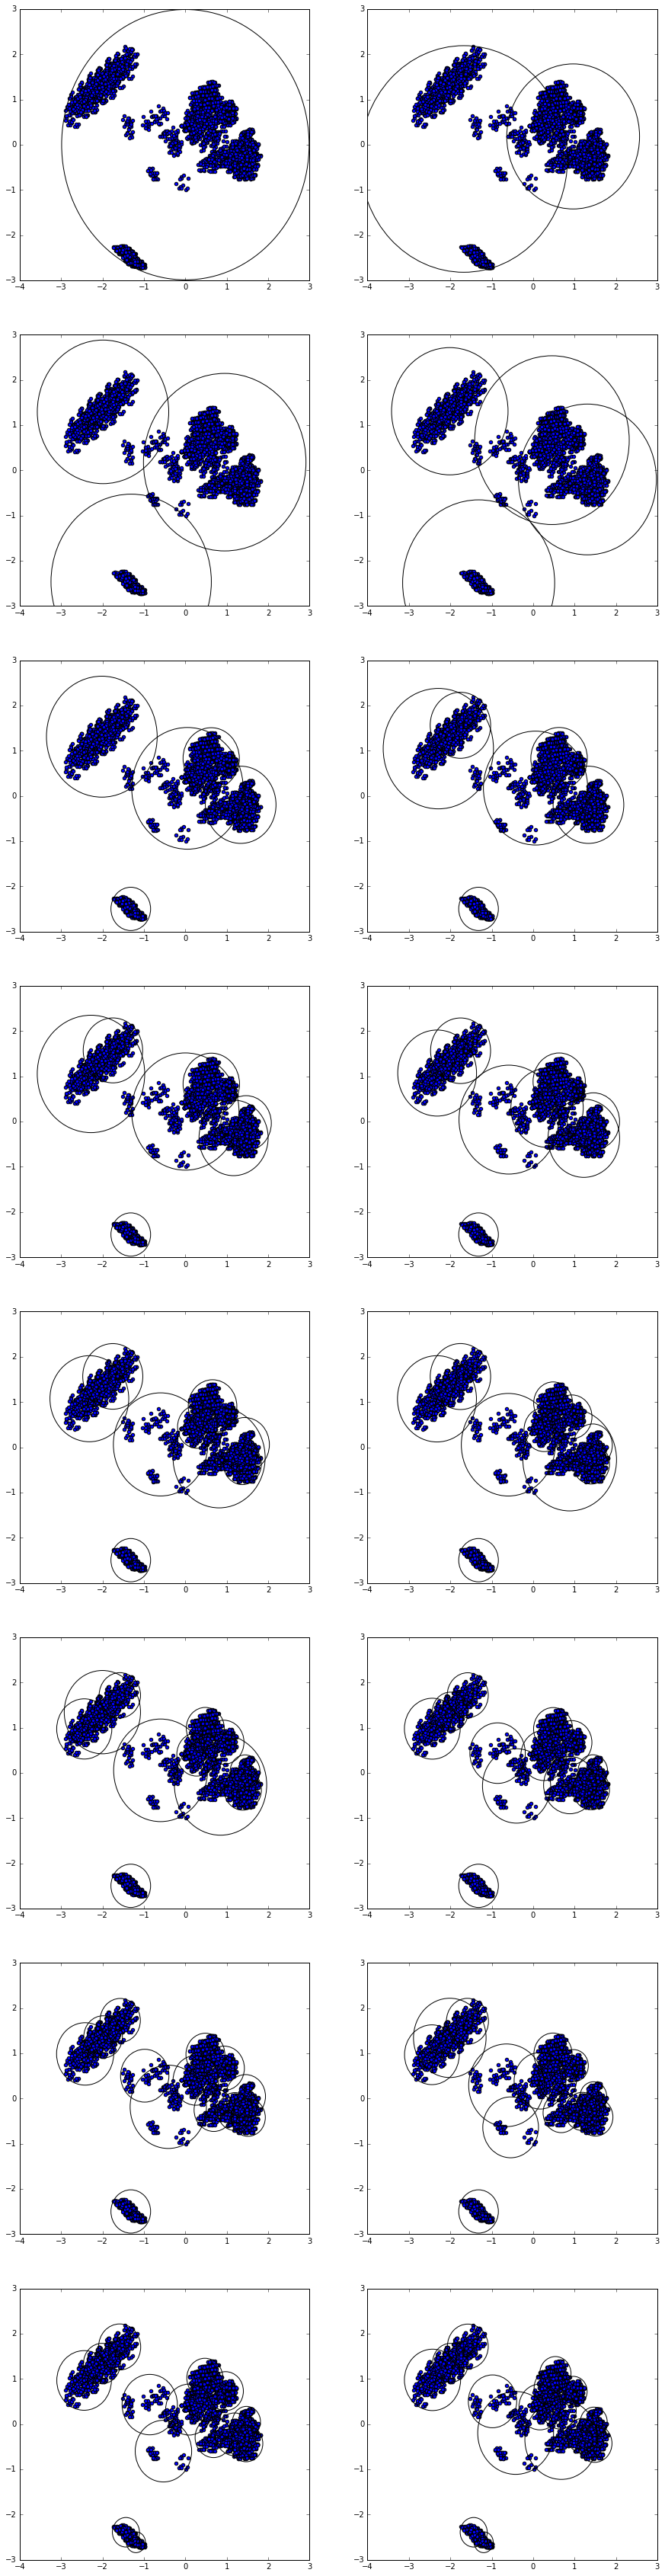

In [6]:
def P3():

    plt.figure(figsize=(15, 60))

    n_comp = 2
    pca_mod = PCA(n_components = 2)
    train_data_transformed = pca_mod.fit_transform(train_data)

    for i in range(16):
        # Set up the plot
        ax = plt.subplot(8, 2, i+1)
        # Set up k-means 
        km = KMeans(n_clusters=i+1, init='k-means++')
        # Train the clustering algorithm
        clstrs = km.fit(train_data_transformed)

        # Set the centers
        centers = [(clstrs.cluster_centers_[j,0],clstrs.cluster_centers_[j,1]) for j in range(i+1)]
        dists = km.transform(train_data_transformed)

        ax.scatter(train_data_transformed[:, 0], train_data_transformed[:, 1])
        #plt.title("PCA Sample Data")
        #plt.xlabel("Principle Component 1")
        #plt.ylabel("Principle Component 2")

        for j in range(i+1):
            circle = plt.Circle(centers[j], np.max(dists[clstrs.labels_ == j,j]),edgecolor='black',fill=False)
            ax.add_artist(circle)



P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

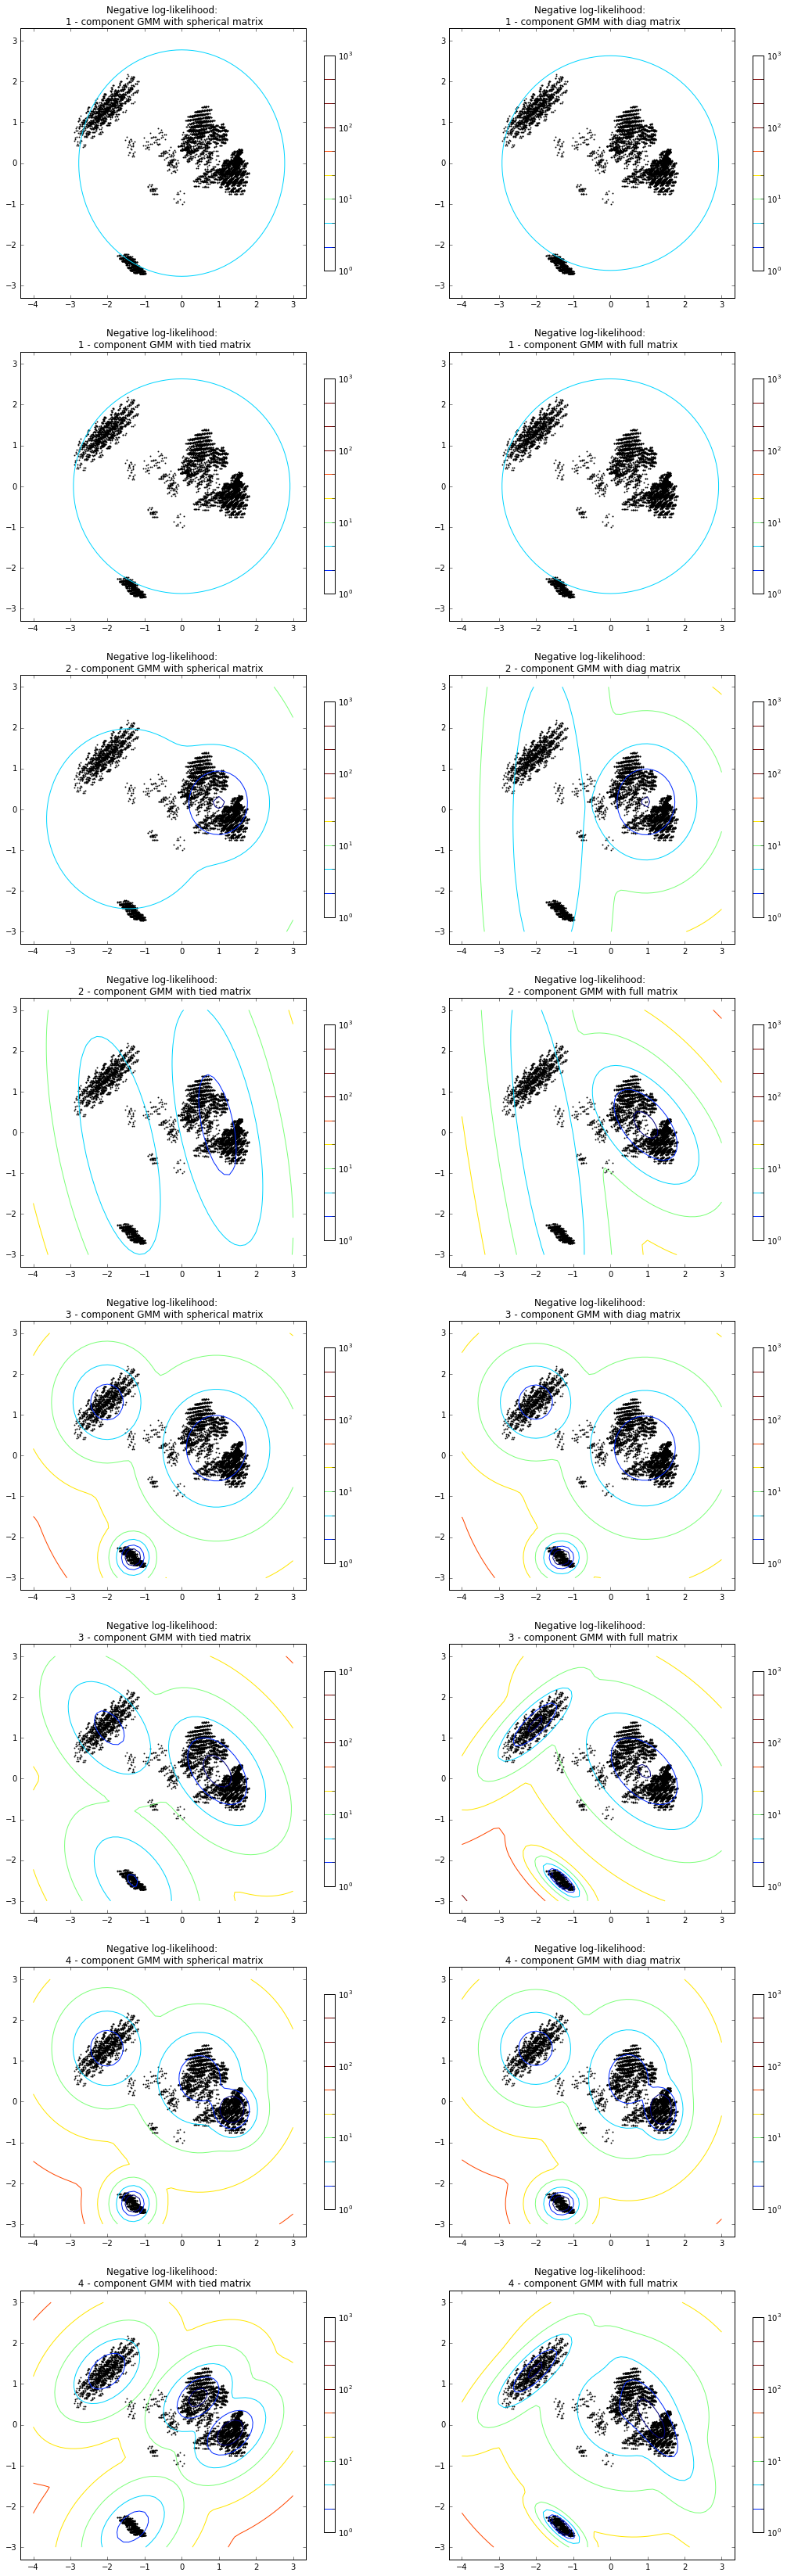

In [7]:
def P4():

    plt.figure(figsize=(18, 58))
    components = [1,2,3,4]
    covariance = ["spherical","diag","tied","full"]
    
    n_comp = 2
    pca_mod = PCA(n_components = 2)
    train_data_transformed = pca_mod.fit_transform(train_data)

    for i in range(4):
        for j in range(4):

            # Set up the plot
            cnt = 4*i + j + 1
            ax = plt.subplot(8, 2, cnt)

            # fit a Gaussian Mixture Model
            clf = GMM(n_components=components[i], covariance_type=covariance[j])
            clf.fit(train_data_transformed)

            # display predicted scores by the model as a contour plot
            x = np.linspace(-4., 3.)
            y = np.linspace(-3., 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)[0]
            Z = Z.reshape(X.shape)

            CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                             levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            ax.scatter(train_data_transformed[:, 0], train_data_transformed[:, 1], .8)

            plt.title('Negative log-likelihood: \n %i - component GMM with %s matrix' %(components[i],covariance[j]))

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
def P5():
        
    n_comp = 2
    pca_mod = PCA(n_components = 2)
    train_data_transformed = pca_mod.fit_transform(train_data)

    # Pull out positive and negative training data
    positive = train_data_transformed[train_labels == 1, :]
    negative = train_data_transformed[train_labels == 0, :]

    # Fit a positive model
    clf_pos = GMM(n_components=4, covariance_type='full')
    clf_pos.fit(positive)

    # Fit a negative model
    clf_neg = GMM(n_components=4, covariance_type='full')
    clf_neg.fit(negative)

    # Apply the PCA transformation to the test data:
    test_data_transformed = pca_mod.transform(test_data)

    # Predict the test data
    test_probs_under_pos = clf_pos.score(test_data_transformed)

    # Predict the test data
    test_probs_under_neg = clf_neg.score(test_data_transformed)

    # Predict positive by if logprob uder positive is greater
    test_preds = np.zeros(1124)
    for i in range(1124):
        if test_probs_under_pos[i] > test_probs_under_neg[i]:
            test_preds[i] = 1

    # Report the accuracy
    correct, total = 0, 0
    for pred, label in zip(test_preds, test_labels):
        if pred == label: correct += 1
        total += 1
    print('total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total))
        
P5()

total: 1124  correct: 1069  accuracy: 0.95
